In [ ]:
import segmentation_models_pytorch as smp
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights, lraspp_mobilenet_v3_large, deeplabv3_resnet101

#Hyperparamters
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet' #pretrained weighting
#CLASSES = ["background", "skin", "nose", "right_eye", "left_eye", "right_brow", "left_brow", "right_ear", "left_ear", "mouth_interior", "top_lip", "bottom_lip", "neck", "hair", "beard", "clothing", "glasses", "headwear", "facewear"]
ACTIVATION = "sigmoid" # softmax2d for multiclass segmentation
num_classes = 12

"""
aux_params=dict(
    pooling='avg',       # one of 'avg', 'max'
    classes=num_classes, 
    activation = None
)
"""

#DEEPLABV3+

deeplab = smp.DeepLabV3Plus(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    #aux_params=aux_params
)


#UNET
unet = smp.Unet(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    decoder_use_batchnorm = True,
    #aux_params=aux_params
)

fcn = smp.FPN(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
)

mobile = smp.Unet(
    in_channels=3,
    encoder_name="mobilenet_v2", 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
from segmentation_models_pytorch import utils
import os

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set device: `cuda` or `cpu`
#"cuda" if torch.cuda.is_available() else
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#loss = smp.utils.losses.BCELoss()
#loss = FocalLoss("multilabel", alpha=0.25, gamma=4)
#weights = torch.tensor([0.7526, 0.4953, 0.9898, 0.9910, 0.9942, 0.9942, 0.9579, 0.9940, 0.9931,
#        0.9895, 0.8484])

#loss = SoftBCEWithLogitsLoss(pos_weight=normedWeights)
loss = smp.utils.losses.CrossEntropyLoss()

# define evalusation metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


In [ ]:
import matplotlib.pyplot as plt

def train_model(model, train_loader_given, valid_loader_given, saveas, epoch):

    #clear CUDA cache
    torch.cuda.empty_cache()

    # define optimizer
    #optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

    # define learning rate scheduler
    #lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer)

    #define train ecpochs w/ our hyperparams
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    #define train ecpochs w/ our hyperparams
    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    if TRAINING:

        best_iou_score = 0.0
        train_logs_list, valid_logs_list = [], []

        #Keep track of epoch BCE and IoU for graph plots
        epoch_count = []
        v_bce = []
        v_ious = []

        t_bce = []
        t_ious = []

        i = 0
        while i < epoch:
            i +=1 

            # Perform training & validation
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader_given)
            valid_logs = valid_epoch.run(valid_loader_given)
            #lr_scheduler.step()

            #log
            train_logs_list.append(train_logs)
            valid_logs_list.append(valid_logs)

            # Save model if a better val IoU score is obtained
            if best_iou_score < valid_logs['iou_score']:
                best_iou_score = valid_logs['iou_score']
                torch.save(model, saveas)
                print('Model saved!')

            v_ious.append(valid_logs['iou_score'])
            t_ious.append(train_logs['iou_score'])
            
            epoch_count.append(i)
        
            # Plot graph every 2 epochs
            if i % 2 ==0:
                plt.show()
                plt.plot(epoch_count,t_ious, label="Train IoU")
                plt.plot(epoch_count,v_ious, label="Valid IoU")
                plt.legend(loc="upper left")
                plt.xlabel("Epochs")
                plt.ylabel("IoU")
                plt.show()



Epoch: 1
valid: 100%|██████████| 30/30 [00:03<00:00,  8.81it/s, cross_entropy_loss - 1.785, iou_score - 0.5444]
Model saved!

Epoch: 2
valid: 100%|██████████| 30/30 [00:03<00:00,  8.89it/s, cross_entropy_loss - 1.742, iou_score - 0.6062]
Model saved!


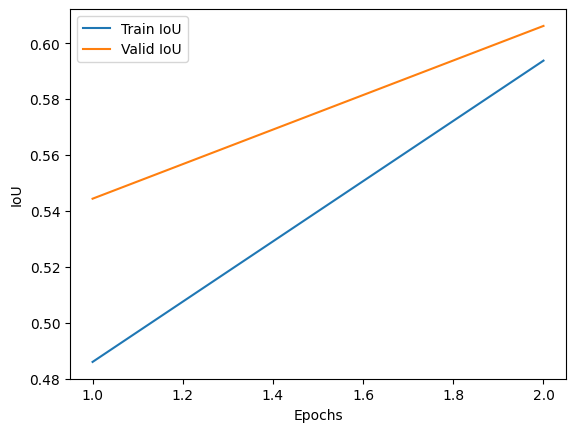


Epoch: 3
valid: 100%|██████████| 30/30 [00:03<00:00,  9.09it/s, cross_entropy_loss - 1.73, iou_score - 0.6154] 
Model saved!

Epoch: 4
valid: 100%|██████████| 30/30 [00:03<00:00,  8.98it/s, cross_entropy_loss - 1.725, iou_score - 0.6272]
Model saved!


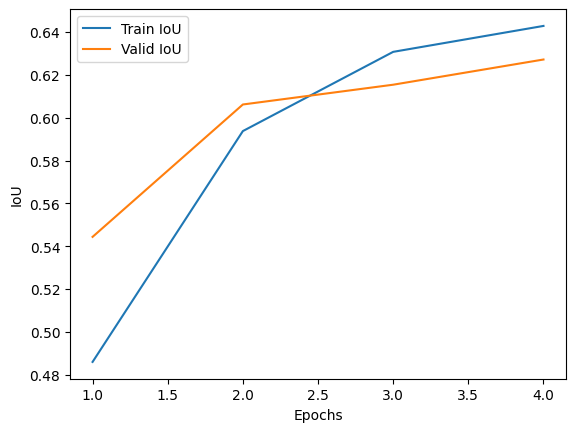


Epoch: 5
valid: 100%|██████████| 30/30 [00:03<00:00,  8.97it/s, cross_entropy_loss - 1.722, iou_score - 0.6486]
Model saved!

Epoch: 6
valid: 100%|██████████| 30/30 [00:03<00:00,  9.05it/s, cross_entropy_loss - 1.72, iou_score - 0.6375] 


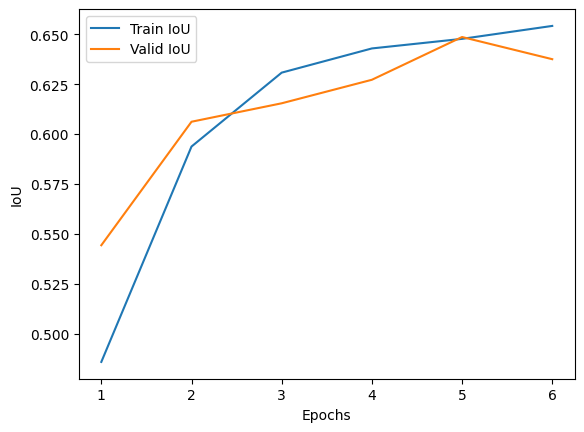


Epoch: 7
valid: 100%|██████████| 30/30 [00:03<00:00,  8.97it/s, cross_entropy_loss - 1.719, iou_score - 0.6462]

Epoch: 8
valid: 100%|██████████| 30/30 [00:03<00:00,  9.14it/s, cross_entropy_loss - 1.719, iou_score - 0.6501]
Model saved!


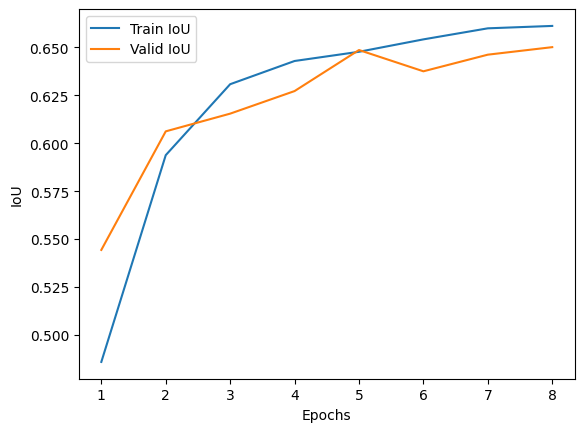


Epoch: 9
valid: 100%|██████████| 30/30 [00:03<00:00,  9.14it/s, cross_entropy_loss - 1.716, iou_score - 0.657] 
Model saved!

Epoch: 10
valid: 100%|██████████| 30/30 [00:03<00:00,  9.14it/s, cross_entropy_loss - 1.715, iou_score - 0.6453]


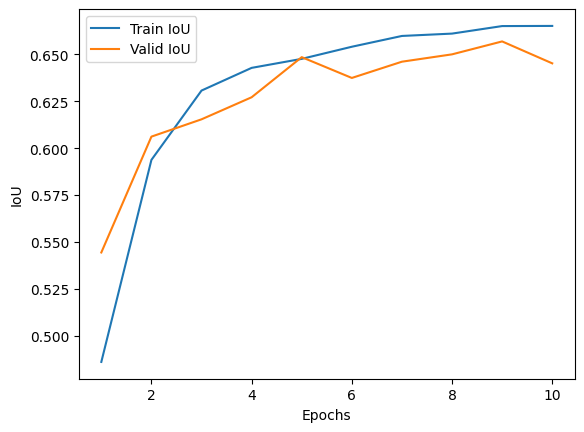


Epoch: 11
valid: 100%|██████████| 30/30 [00:03<00:00,  9.07it/s, cross_entropy_loss - 1.715, iou_score - 0.6561]

Epoch: 12
valid: 100%|██████████| 30/30 [00:03<00:00,  9.16it/s, cross_entropy_loss - 1.713, iou_score - 0.6663]
Model saved!


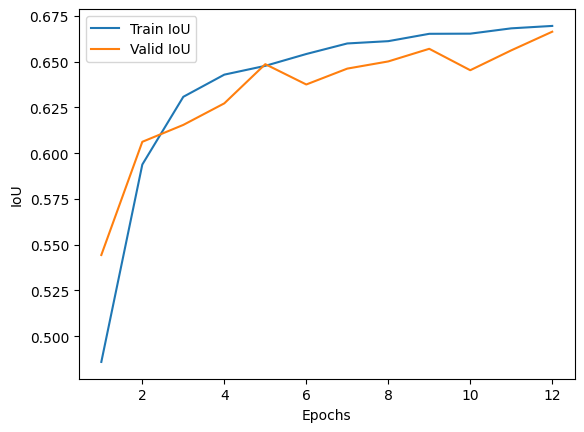


Epoch: 13
valid: 100%|██████████| 30/30 [00:03<00:00,  8.98it/s, cross_entropy_loss - 1.712, iou_score - 0.6621]

Epoch: 14
valid: 100%|██████████| 30/30 [00:03<00:00,  8.99it/s, cross_entropy_loss - 1.713, iou_score - 0.6613]


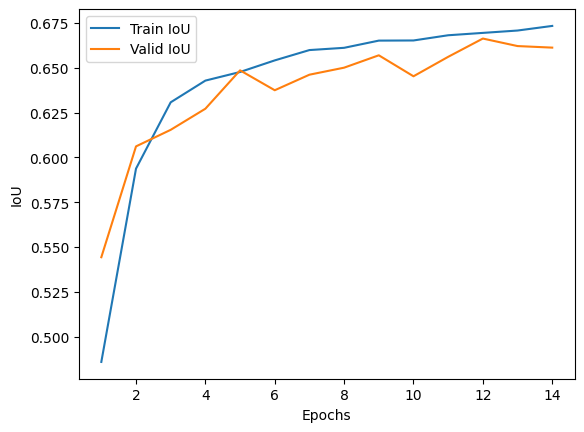


Epoch: 15
valid: 100%|██████████| 30/30 [00:03<00:00,  8.94it/s, cross_entropy_loss - 1.711, iou_score - 0.6678]
Model saved!

Epoch: 16
valid: 100%|██████████| 30/30 [00:03<00:00,  8.86it/s, cross_entropy_loss - 1.712, iou_score - 0.6694]
Model saved!


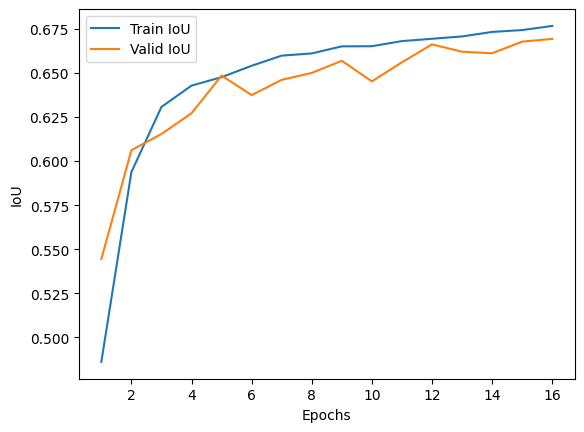


Epoch: 17
train:  53%|█████▎    | 63/119 [00:20<00:18,  3.06it/s, cross_entropy_loss - 1.705, iou_score - 0.6797]


KeyboardInterrupt: 

In [ ]:
train_model(mobile, train_loader2, valid_loader2, "/home/nathan/Documents/final_project/saved_models/label_adapted_wood.pth", 50)

/tmp/ipykernel_15441/3072871198.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
/tmp/ipykernel_15441/3072871198.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = label_test_script.colour_code_segmentation(label_test_script.reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


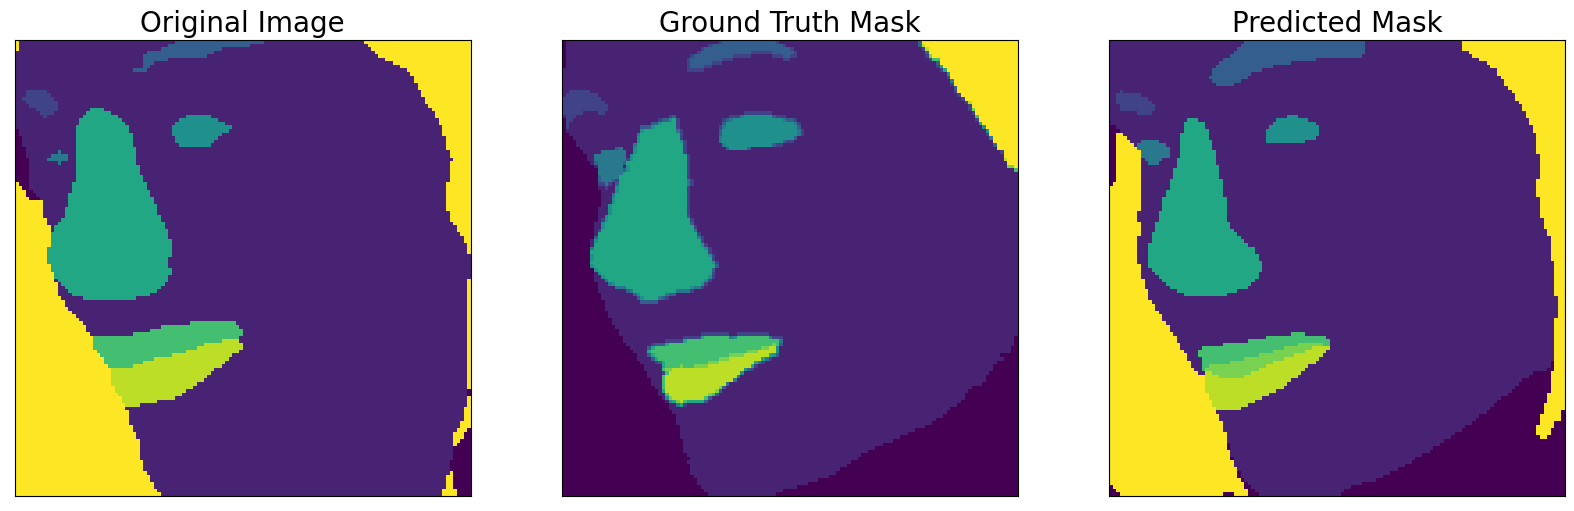

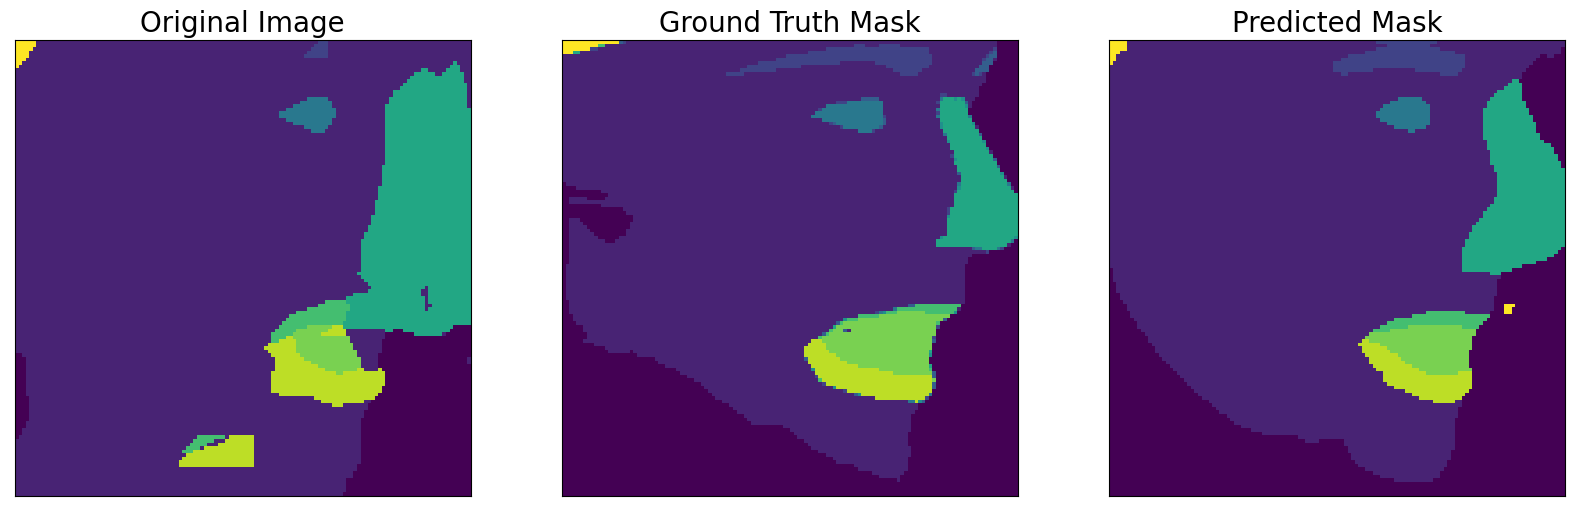

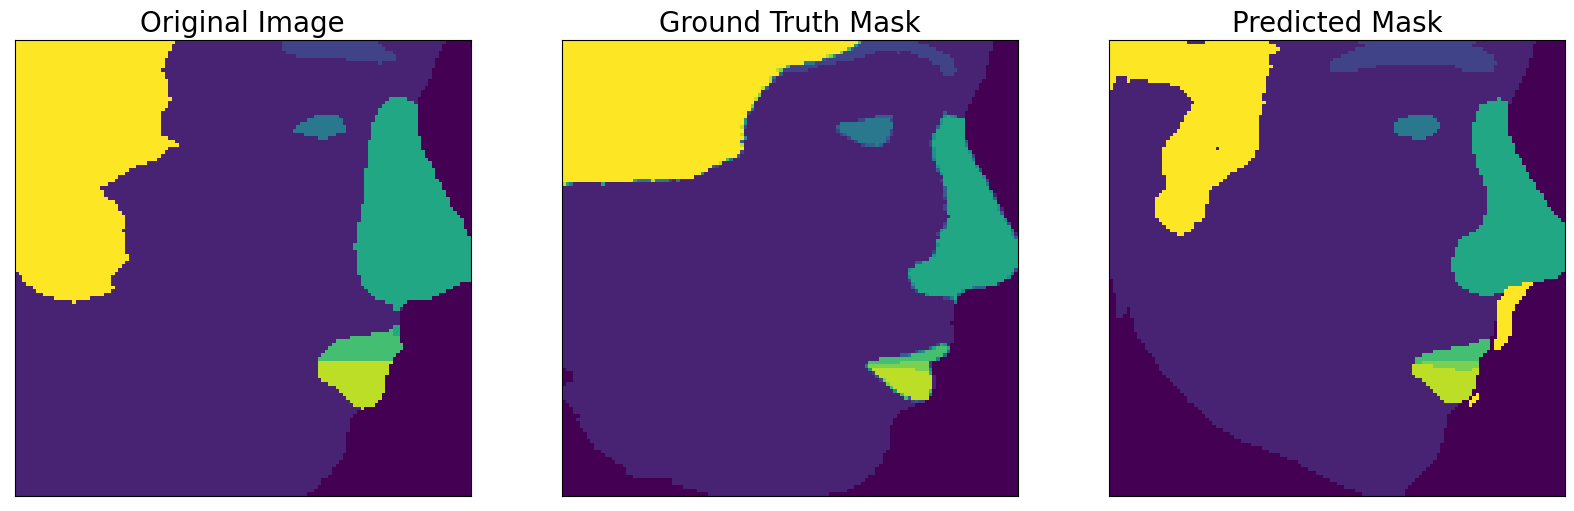

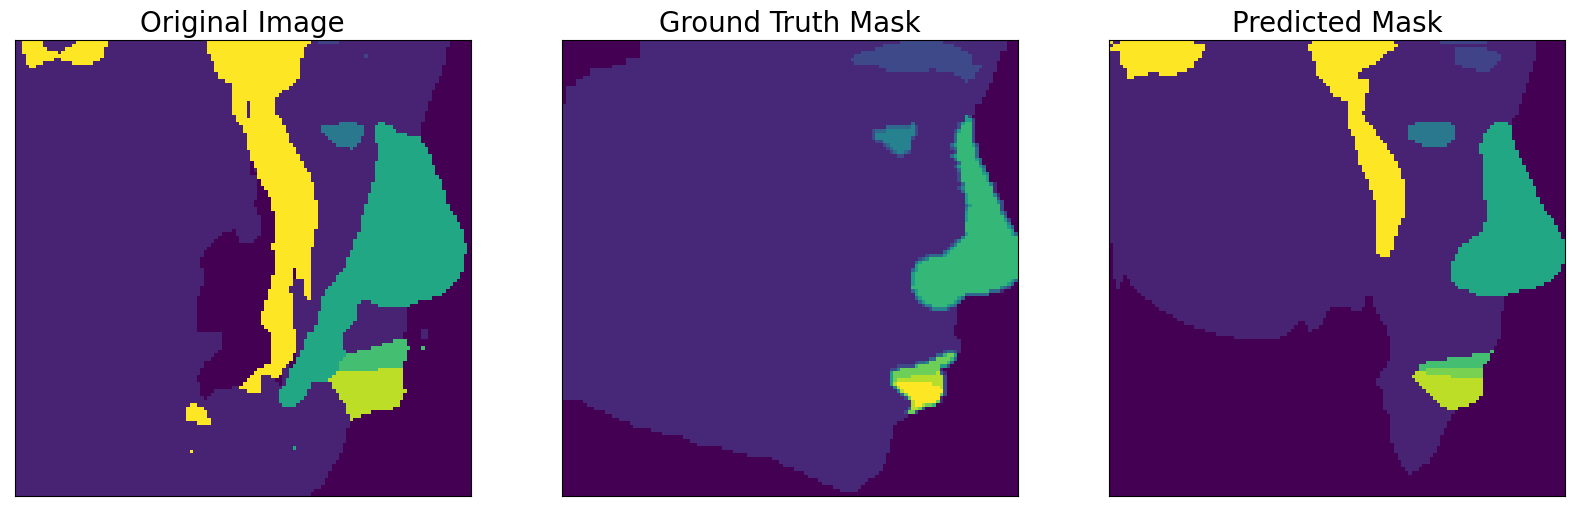

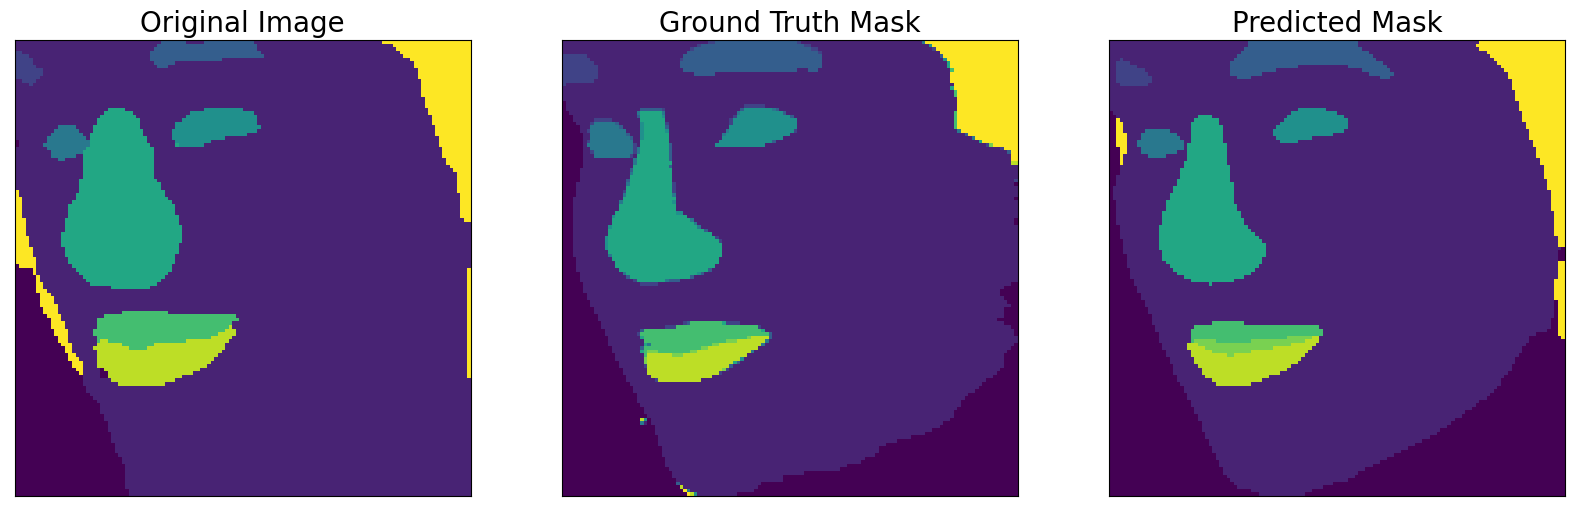

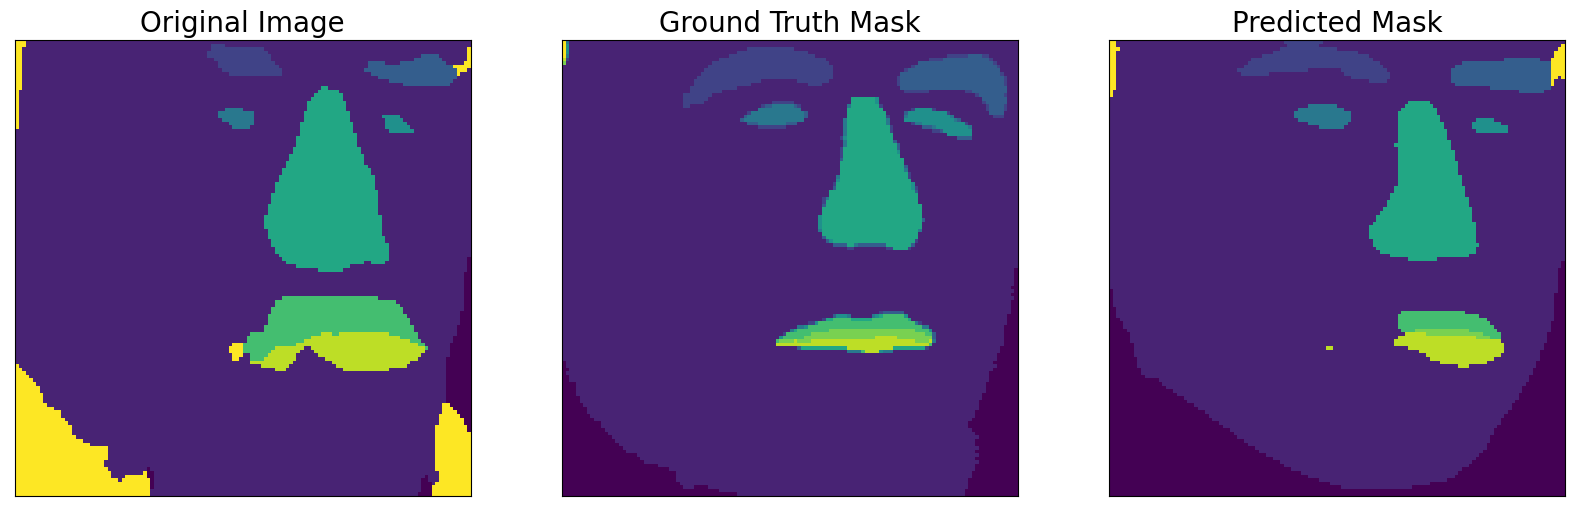

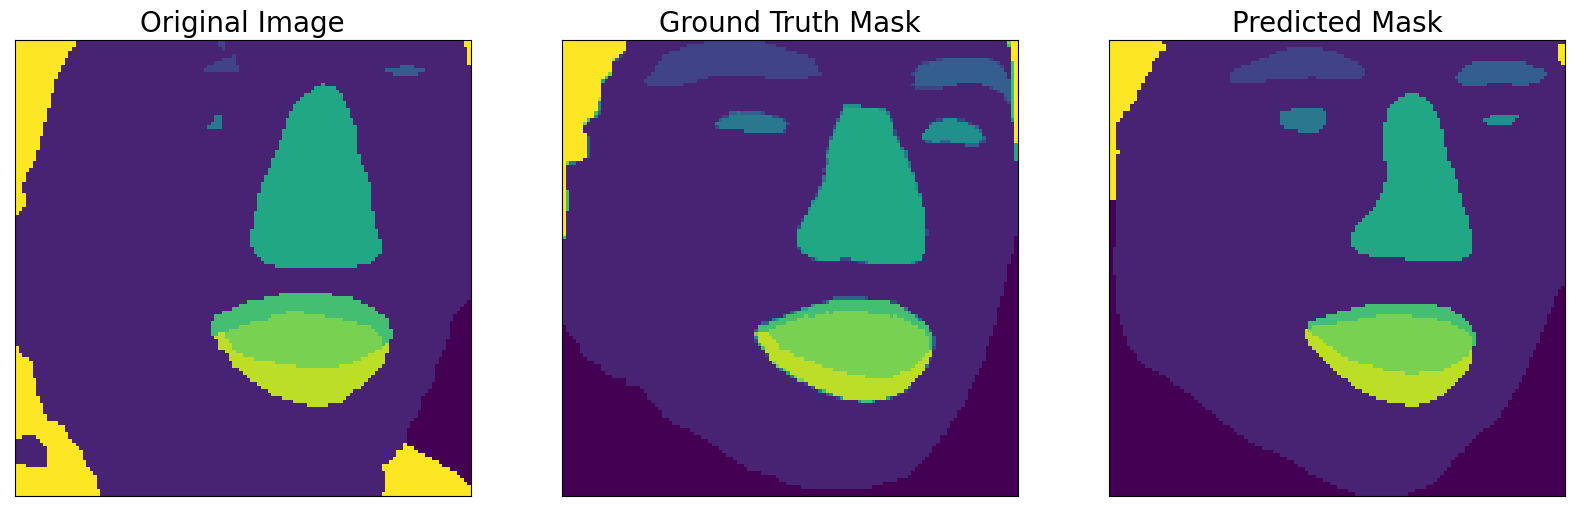

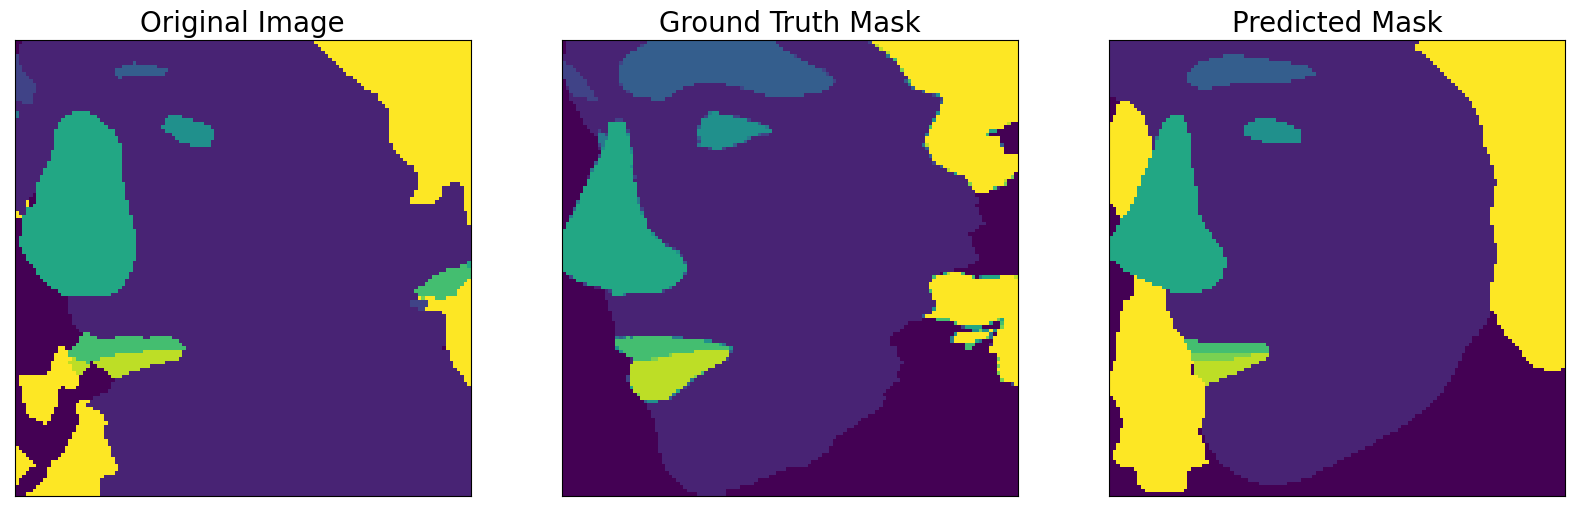

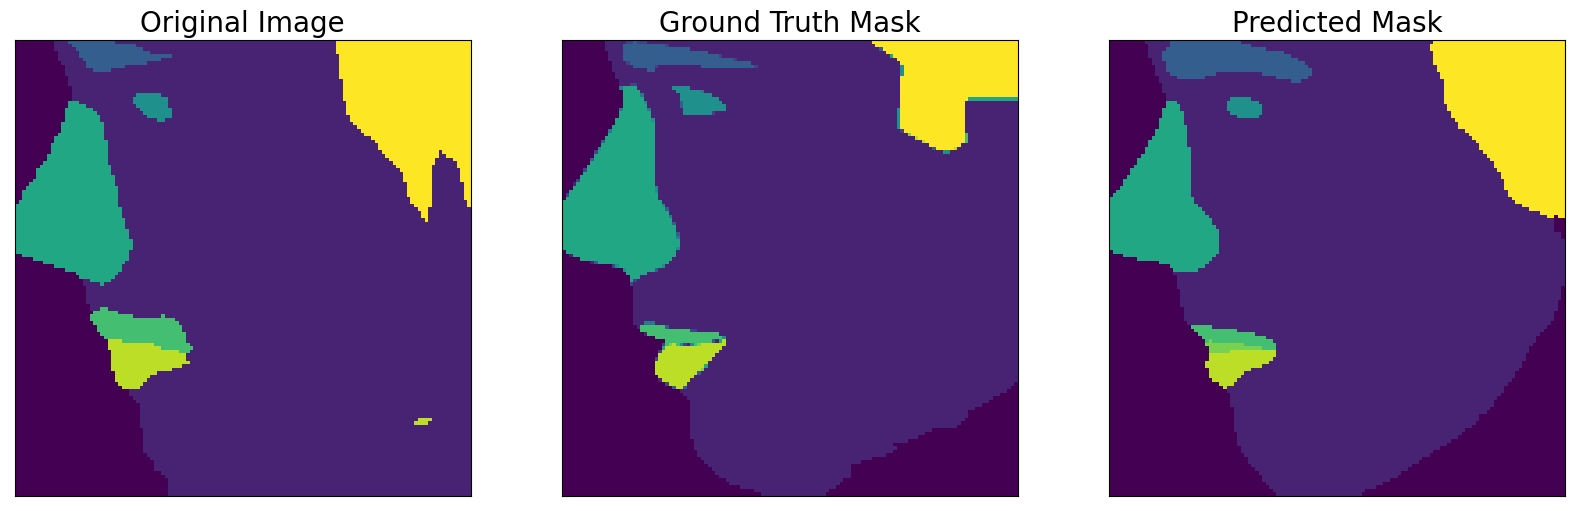

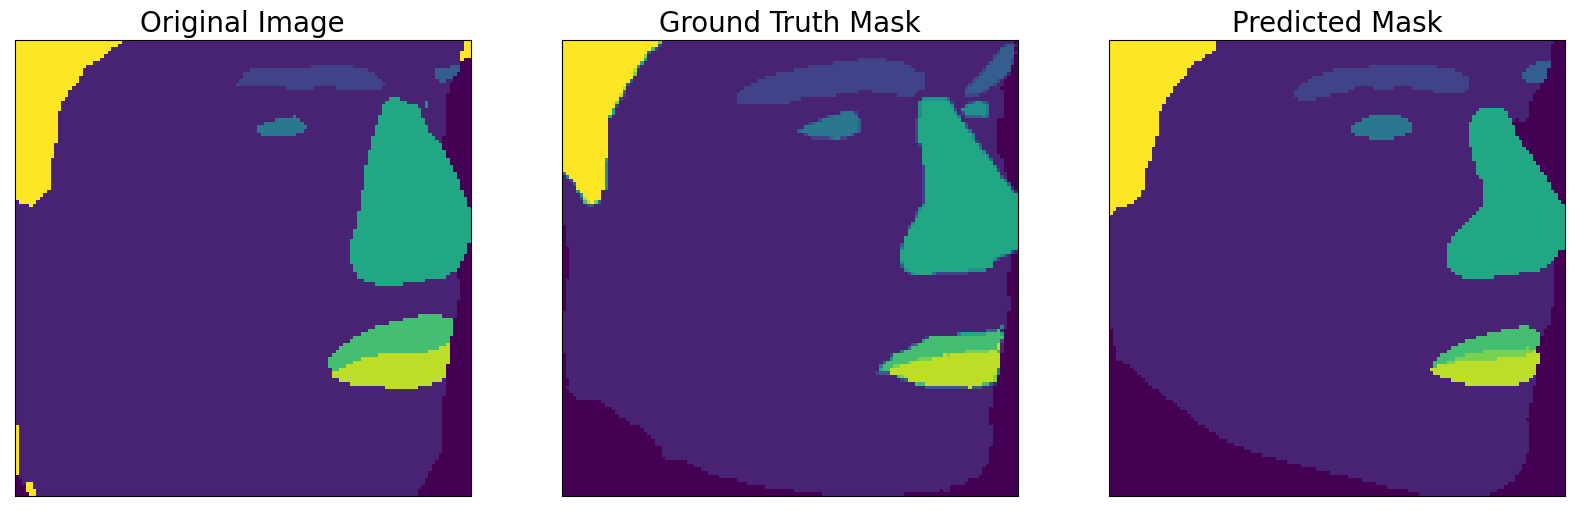

KeyboardInterrupt: 

In [ ]:
import label_test_script

rgb_vals = [ 0,1,2,3,4,5,6,7,8,9,10,11]

model = torch.load("/home/nathan/Documents/final_project/saved_models/label_adapted_wood.pth", map_location=DEVICE)

view_label_predictions(model,val_ds2, num_classes)